<a id="TOP"></a>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=150/><img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=200/> 

***

# NASA ISRO Synthetic Aperture Radar Mission
## Query and Download from ASF DAAC
## Preprocess NISAR-simulated UAVSAR products 

Authors: Alex Christensen


## 1 &emsp; Import Python Modules

In [5]:
import os
from pathlib import Path
import sys

notebook_dir = Path(os.getcwd())
main_dir = notebook_dir.resolve().parents[0]

print(notebook_dir)
print(main_dir)

/Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks
/Users/alchrist/Documents/GitHub/nisar-crop-area


In [30]:

# import matplotlib.pyplot as plt

from osgeo import gdal, osr
# import subprocess

# import time
# import scipy
# from pandas import DataFrame
# from IPython.display import Image
# import sklearn  # imported from scikit-learn
# from sklearn import metrics


# from ipywidgets import interactive
# from rasterio.plot import show_hist

import geopandas as gpd
from shapely.geometry import shape, Polygon

import wget
from math import pi

import rasterio
import rasterio.mask
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [7]:
## function to convert GRD to TIF
## code originally written by Josef Kellndorfer


def grd2tif(folder,product_id, dl, overwrite=True):
    # Make the annotation dictionary
    ann = folder / os.path.basename(dl[product_id]['ann'])
    
    with open(ann, "r") as f:
        lines = f.readlines()
    # Skip comments and empty lines
    lines = [x for x in lines if (not x.startswith(';') and (not x.startswith('\n')))]
    validline = False
    anndict = {}
    for l in lines:
        if l.startswith('slc_mag.set_rows'):
            validline = True
        if not validline or l.startswith('comments'):
            next
        else:
            key = l.split()[0]
            units = l.split('(')[1].split(')')[0]
            value = l.split('=')[1].split()[0].strip(' ')
            anndict[key] = {'units': units, 'value': value}
            
    # Get the row/cols
    cols = int(anndict['grd_pwr.set_cols']['value'])
    rows = int(anndict['grd_pwr.set_rows']['value'])

    # Read the grds and rtcf into numpy arrays
    ## Get the local filenames
    hh_name = folder / os.path.basename(dl[product_id]['hh'])
    hv_name = folder / os.path.basename(dl[product_id]['hv'])
    rtcf_name = folder / os.path.basename(dl[product_id]['rtcf'])
    inc_name = folder / os.path.basename(dl[product_id]['inc'])
    flatinc_name = folder / os.path.basename(dl[product_id]['flatinc'])
    ## Read into numpy arrays and reshape to row/cols dimensions
    hh = np.fromfile(hh_name, dtype=np.float32).reshape((rows, cols))
    hv = np.fromfile(hv_name, dtype=np.float32).reshape((rows, cols))
    rtcf = np.fromfile(rtcf_name, dtype=np.float32).reshape((rows, cols))
    inc = np.fromfile(inc_name, dtype=np.float32).reshape((rows, cols))
    flatinc = np.fromfile(flatinc_name, dtype=np.float32).reshape((rows, cols))

    # Mask for NISAR Inc. Angle Range
    ## Build Mask
    nisar_near_range_inc_deg = 33
    nisar_far_range_inc_deg = 47
    nisar_near_range_inc_rad = nisar_near_range_inc_deg / 180 * pi
    nisar_far_range_inc_rad = nisar_far_range_inc_deg / 180 * pi
    mask_nisar_inc = ~((flatinc >= nisar_near_range_inc_rad) & (flatinc <= nisar_far_range_inc_rad))
    ## Apply mask to grd and rtcf arrays
    hh_masked = np.ma.array(hh, mask=mask_nisar_inc, fill_value=np.nan)
    hv_masked = np.ma.array(hv, mask=mask_nisar_inc, fill_value=np.nan)
    rtcf_masked = np.ma.array(rtcf, mask=mask_nisar_inc, fill_value=np.nan)
    inc_masked = np.ma.array(inc, mask=mask_nisar_inc, fill_value=np.nan)

    # Apply rtcf to grd to generate rtc products
    hh_rtc = hh_masked * rtcf_masked / np.cos(inc_masked)
    hv_rtc = hv_masked * rtcf_masked / np.cos(inc_masked)

    drv = gdal.GetDriverByName('GTiff')

    # Set the geotransformation tuple
    xres = float(anndict['grd_pwr.col_mult']['value'])
    yres = float(anndict['grd_pwr.row_mult']['value'])
    # set upper left pixel as pixel as Area
    ulx = float(anndict['grd_pwr.col_addr']['value']) - xres / 2
    uly = float(anndict['grd_pwr.row_addr']['value']) - yres / 2  # Note that yres is negative
    geotrans = (ulx, xres, 0, uly, 0, yres)

    # Projection info for Lon/lat (EPSG 4326)
    srs = osr.SpatialReference()
    srs.SetWellKnownGeogCS("WGS84")
    proj = srs.ExportToWkt()

    tifnames = []
    for tifname, arr in zip((hh_name, hv_name), (hh_rtc, hv_rtc)):
        tifname = str(tifname).replace('.grd', '.tif')
        # Create Image with geocoding info
        make_image = True
        if os.path.exists(tifname):
            if overwrite:
                os.remove(tifname)
            else:
                make_image = False
                print('Not overwriting existing', tifname)
        if make_image:
            img = drv.Create(tifname, cols, rows, 1, gdal.GDT_Float32)
            img.SetGeoTransform(geotrans)
            img.SetProjection(proj)
            # Write data to the band
            band = img.GetRasterBand(1)
            # Write raster data
            band.WriteArray(arr.filled())
            # Set no data valye
            band.SetNoDataValue(np.nan)
            # Close the band and image
            band = None
            img = None
            print('Wrote', tifname)

        tifnames.append(tifname)
    drv = None
    return tifnames


In [8]:
input_dir = notebook_dir / 'inputs'
output_dir = notebook_dir / 'outputs'
ancillary_dir = main_dir / 'ancillary_data'


## 2:  Data NISAR-simulated UAVSAR images

## 2.1: Define the AOI
Provide either a geojson defining the AOI or draw one on the map

In [9]:
aoi = 'NISARP_09811'
aoi_inputs = input_dir/aoi
aoi_outputs = output_dir/aoi
Path(aoi_inputs).mkdir(parents=True, exist_ok=True)
Path(aoi_outputs).mkdir(parents=True, exist_ok=True)


In [10]:
## You can search for available Simulated NISAR data here:
## https://uavsar.jpl.nasa.gov/cgi-bin/data.pl?search=simulated-nisar
root='https://downloaduav.jpl.nasa.gov/Release2u/'

## Example over Wax Lake Delta, Louisiana
product_ids = ['%s_19071_000_191001_L090_CX_02' %(aoi),
              '%s_19054_000_190813_L090_CX_02' %(aoi),
              '%s_19052_000_190726_L090_CX_03' %(aoi),
              '%s_19049_001_190717_L090_CX_03' %(aoi),
              '%s_19044_004_190702_L090_CX_02' %(aoi),
              '%s_19040_000_190621_L090_CX_03' %(aoi)]
product_ids.sort()
mode = '129A'


In [11]:
download_url ='https://downloaduav.jpl.nasa.gov/Release2u/'
dl = {}
for product_id in product_ids:
    dl0 = {'ann': download_url + product_id + '/' + product_id.replace('_CX_', '_CX_%s_'%(mode)) + '.ann',
           'rtcf': download_url + product_id + '/' + product_id.replace('_CX_', '_CX_%s_'%(mode)) + '.rtc',
           'inc': download_url + product_id + '/' + product_id.replace('_CX_','_CX_%s_'%(mode)) + '.inc',
           'flatinc': download_url + product_id + '/' + product_id.replace('_CX_', '_CX_%s_'%(mode)) + '.flat.inc',
           'hh': download_url + product_id + '/' + product_id.replace('_CX_', 'HHHH_CX_%s_'%(mode)) + '.grd',
           'hv': download_url + product_id + '/' + product_id.replace('_CX_', 'HVHV_CX_%s_'%(mode)) + '.grd'}
    dl[product_id] = dl0


## 2.2: Download files.
You must enter your ASF/EarthData login credentials

In [12]:
#donwload the UAVSAR dataset
for dt in dl:
    for i in dl[dt]:
        if os.path.isfile(aoi_inputs/dl[dt][i].split('/')[-1])==False:
            print(f'\n{dl[dt][i]}')
            wget.download(dl[dt][i], out = str(aoi_inputs))
        else: 
            print('already downloaded')


already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded
already downloaded


## 3: Preprocess GCOV products

## 3.1: Convert GRD to Tiff (using code from Josef)

In [17]:
tif_files = []
for i in product_ids:
    hh,hv = grd2tif(Path(aoi_inputs),i,dl,True)
    tif_files.append(hv)
    tif_files.append(hh)


/Users/alchrist/anaconda3/envs/ecosystems_atbd/lib/python3.11/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19040_000_190621_L090HHHH_CX_129A_03.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19040_000_190621_L090HVHV_CX_129A_03.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19044_004_190702_L090HHHH_CX_129A_02.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19044_004_190702_L090HVHV_CX_129A_02.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19049_001_190717_L090HHHH_CX_129A_03.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19049_001_190717_L090HVHV_CX_129A_03.tif
Wrote /Users/alchrist/Documents/GitHub/nisar-crop-area/notebooks/inputs/NISARP_09811/NISARP_09811_19052_000_190726_L090HHHH_CX_129A_03.tif
Wrote /Users/alchrist/Docum

## 3.2: Crop reference image and resample/coregister all images in stack

In [25]:
crop = False #if you want the entire flight frame, change to false

if crop:
    crop_to = gpd.read_file('%s.geojson' %(aoi_inputs/aoi))

    crop_to = crop_to.to_crs(rasterio.CRS.from_epsg(4326))
    
    crop_to.plot()
    crop_to = crop_to.explode()
    shapes = crop_to.geometry

    with rasterio.open(tif_files[i]) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        ref_meta = src.meta
            
else:
    with rasterio.open(tif_files[i]) as src:
        out_image = src.read()
        out_transform = src.transform
        ref_meta = src.meta
            
for i in range(len(tif_files)):

    ref_meta.update({"driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform})
    
    with rasterio.open('%s_subset.tif' %(tif_files[i][:-4]), "w", **ref_meta) as dest:
        dest.write(out_image)

In [34]:
## Delete temporary files

for i in range(len(tif_files)):
    os.system('rm -r %s.tif' %(tif_files[i][:-4]))


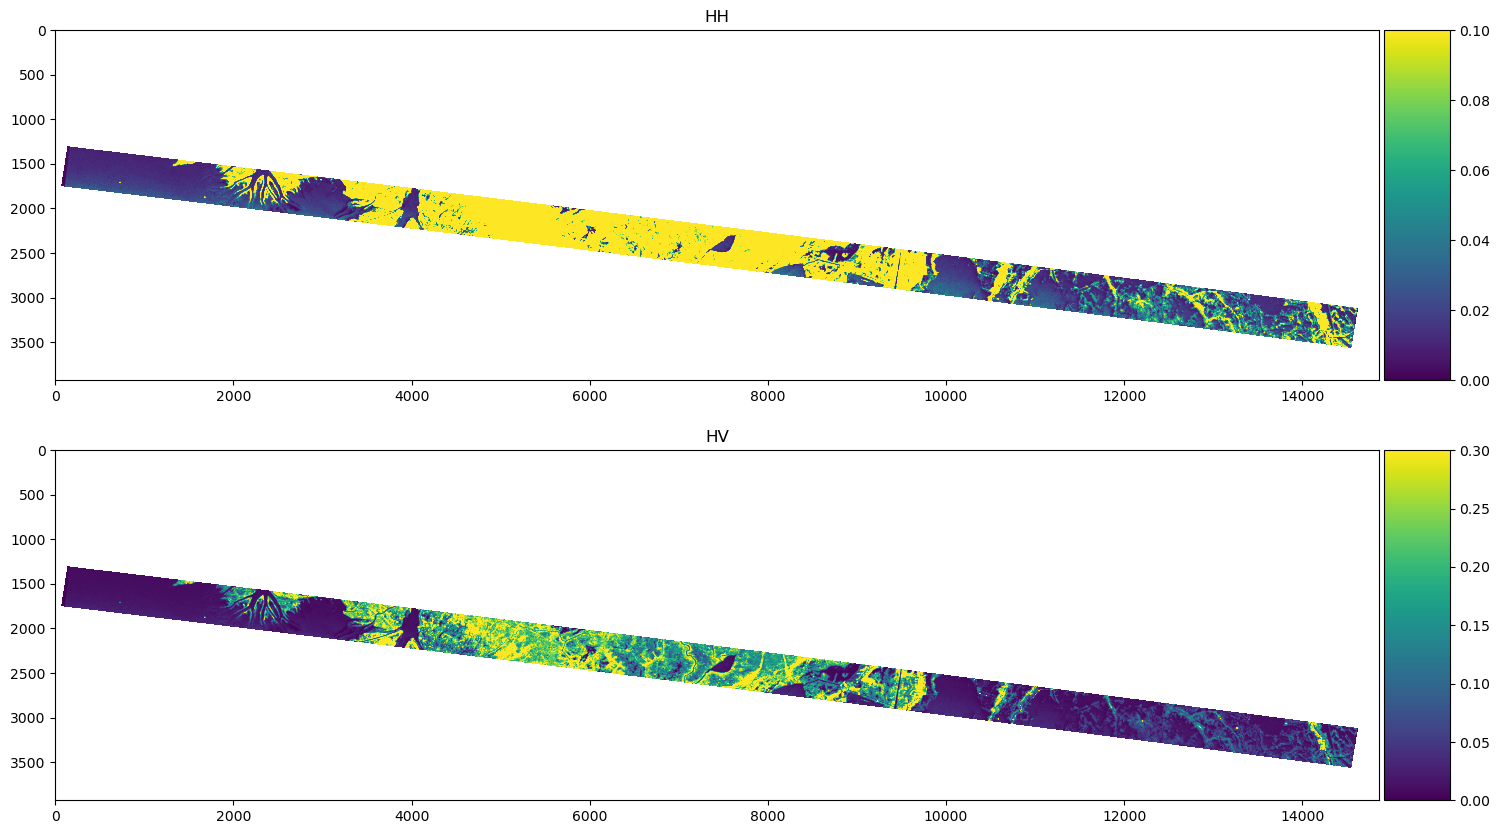

In [33]:
HH = rasterio.open('%s_subset.tif' %(tif_files[0][:-4])).read(1)
HV = rasterio.open('%s_subset.tif' %(tif_files[1][:-4])).read(1)

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))
im1 = ax1.imshow(HH,vmin=0,vmax=.1)
im2 = ax2.imshow(HV,vmin=0,vmax=.3)
ax1.set_title('HH')
ax2.set_title('HV')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');